In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import os

In [4]:
# May need specific imports for windrose depending on installation
# from windrose import WindroseAxes

# Replace <country> and <filename> with your details
file_path = '../data/sierraleone-bumbuna.csv' # e.g., 'data/benin_data.xlsx' or 'data/benin_data.csv'
df = pd.read_csv(file_path)
# If Excel: df = pd.read_excel(file_path)

In [5]:
print("Summary Statistics:")
print(df.describe())

print("\nMissing Values Count:")
missing_counts = df.isna().sum()
print(missing_counts)

print("\nColumns with >5% Nulls:")
total_rows = len(df)
high_null_cols = missing_counts[missing_counts / total_rows > 0.05]
print(high_null_cols)

Summary Statistics:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      201.957515     116.376337     113.720571     206.643095   
std       298.495150     218.652659     158.946032     300.896893   
min       -19.500000      -7.800000     -17.900000       0.000000   
25%        -2.800000      -0.300000      -3.800000       0.000000   
50%         0.300000      -0.100000      -0.100000       3.600000   
75%       362.400000     107.000000     224.700000     359.500000   
max      1499.000000     946.000000     892.000000    1507.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      198.114691      26.319394      79.448857       1.146113   
std       288.889073       4.398605      20.520775       1.239248   
min         0.000000      12.300000       9.900000       0.000000   
25%         0

In [8]:
ccols_for_outlier_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Calculate Z-scores, handle potential NaNs
z_scores = df[cols_for_outlier_check].apply(lambda x: np.abs(zscore(x, nan_policy='omit')))

# Flag rows where any Z-score is > 3
outlier_flag = (z_scores > 3).any(axis=1)
df['is_outlier_flagged'] = outlier_flag # Add flag as a new column

print(f"\nNumber of rows flagged as potential outliers: {outlier_flag.sum()}")

# Basic Cleaning: Handle Missing Values (choose one strategy)
# Strategy 1: Drop rows with NaNs in key columns
# key_cols_to_check_na = ['GHI', 'DNI', 'DHI', 'Tamb'] # Define key columns
# df_cleaned = df.dropna(subset=key_cols_to_check_na).copy()
# print(f"Rows remaining after dropping NaNs in key columns: {len(df_cleaned)}")

# Strategy 2: Impute missing values with the median in key columns
key_cols_to_impute = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust', 'Tamb', 'RH', 'BP'] # Add other relevant columns
for col in key_cols_to_impute:
    if col in df.columns:
         # Calculate the median for the current column, ignoring NaNs
        median_value = df[col].median()
        # Fill NaNs in the column and assign the result back to the column
        df[col] = df[col].fillna(median_value)

df_cleaned = df.copy() # If imputing, the cleaned data is the same DataFrame after imputation
os.makedirs('data', exist_ok=True)
output_path = '../data/sierraleone_clean.csv'  # Replace <country>
df_cleaned.to_csv(output_path, index=False)

print(f"Cleaned data exported to {output_path}")

print("\nMissing values after imputation:")
print(df_cleaned.isna().sum()) # Should show 0 for imputed columns


Number of rows flagged as potential outliers: 16292
Cleaned data exported to ../data/sierraleone_clean.csv

Missing values after imputation:
Timestamp                  0
GHI                        0
DNI                        0
DHI                        0
ModA                       0
ModB                       0
Tamb                       0
RH                         0
WS                         0
WSgust                     0
WSstdev                    0
WD                         0
WDstdev                    0
BP                         0
Cleaning                   0
Precipitation              0
TModA                      0
TModB                      0
Comments              525600
is_outlier_flagged         0
dtype: int64


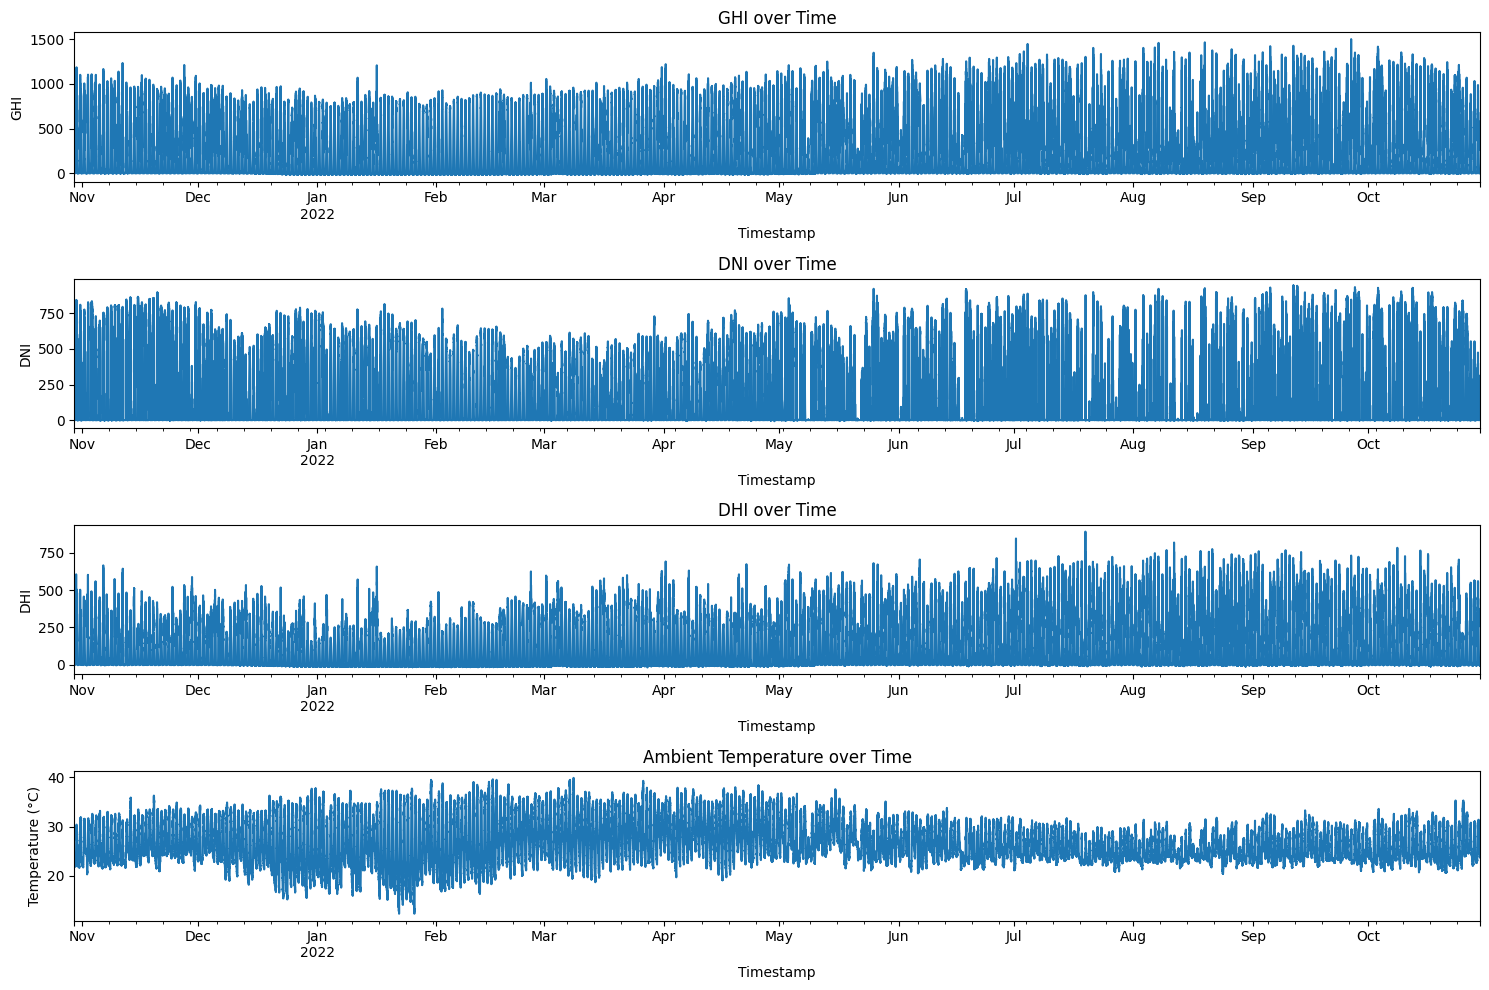

In [9]:
df_cleaned['Timestamp'] = pd.to_datetime(df_cleaned['Timestamp'])
df_cleaned.set_index('Timestamp', inplace=True) # Set Timestamp as index for easier plotting

plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
df_cleaned['GHI'].plot()
plt.title('GHI over Time')
plt.ylabel('GHI')

plt.subplot(4, 1, 2)
df_cleaned['DNI'].plot()
plt.title('DNI over Time')
plt.ylabel('DNI')

plt.subplot(4, 1, 3)
df_cleaned['DHI'].plot()
plt.title('DHI over Time')
plt.ylabel('DHI')

plt.subplot(4, 1, 4)
df_cleaned['Tamb'].plot()
plt.title('Ambient Temperature over Time')
plt.ylabel('Temperature (°C)')
plt.xlabel('Timestamp')

plt.tight_layout()
plt.show()

# You can also resample for daily or monthly patterns if needed
# df_cleaned['GHI'].resample('D').mean().plot()
# df_cleaned['GHI'].resample('M').mean().plot()


Average ModA and ModB pre/post Cleaning Flag:
                          ModA        ModB
is_outlier_flagged                        
False               189.764194  181.693908
True                734.298355  711.448607


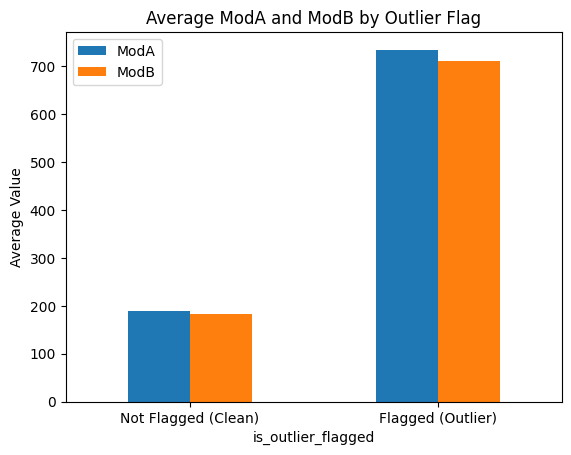

In [10]:
# Ensure ModA and ModB were included in the outlier check/cleaning
cleaning_impact = df.groupby('is_outlier_flagged')[['ModA', 'ModB']].mean()

print("\nAverage ModA and ModB pre/post Cleaning Flag:")
print(cleaning_impact)

cleaning_impact.plot(kind='bar')
plt.title('Average ModA and ModB by Outlier Flag')
plt.ylabel('Average Value')
plt.xticks(ticks=[0, 1], labels=['Not Flagged (Clean)', 'Flagged (Outlier)'], rotation=0)
plt.show()

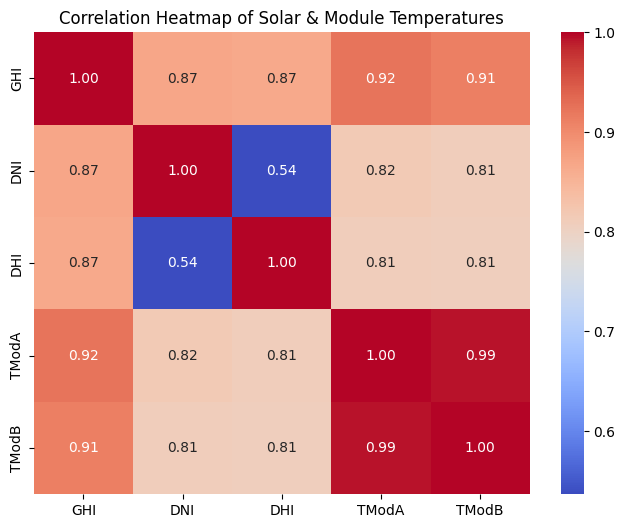

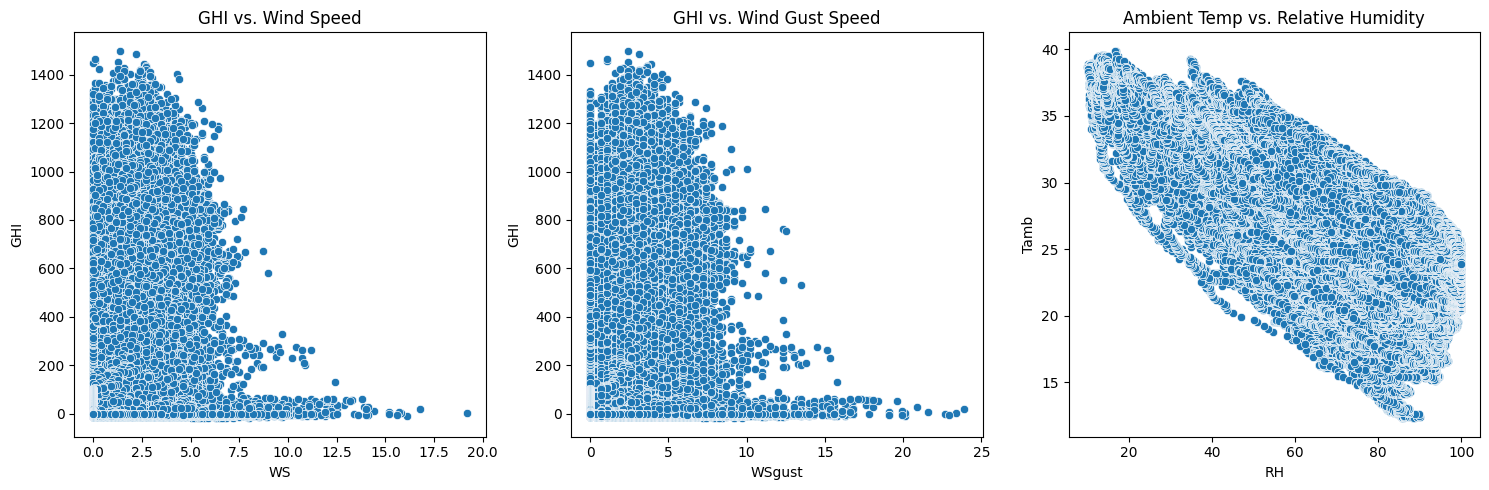

In [11]:
# Select columns for correlation heatmap
correlation_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
if 'TModA' in df_cleaned.columns and 'TModB' in df_cleaned.columns: # Check if columns exist
    correlation_matrix = df_cleaned[correlation_cols].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap of Solar & Module Temperatures')
    plt.show()
else:
     print("TModA or TModB columns not found for correlation heatmap.")
     correlation_cols = ['GHI', 'DNI', 'DHI'] # Fallback if TModA/TModB are missing
     correlation_matrix = df_cleaned[correlation_cols].corr()
     plt.figure(figsize=(8, 6))
     sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
     plt.title('Correlation Heatmap of Solar Irradiance Components')
     plt.show()


# Scatter plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='WS', y='GHI', data=df_cleaned)
plt.title('GHI vs. Wind Speed')

plt.subplot(1, 3, 2)
sns.scatterplot(x='WSgust', y='GHI', data=df_cleaned)
plt.title('GHI vs. Wind Gust Speed')

# WD (Wind Direction) vs GHI - WD is often categorical or cyclical, standard scatter might not be best, consider polar plot later
# sns.scatterplot(x='WD', y='GHI', data=df_cleaned) # Might not be insightful as is

plt.subplot(1, 3, 3)
sns.scatterplot(x='RH', y='Tamb', data=df_cleaned)
plt.title('Ambient Temp vs. Relative Humidity')

# Add RH vs GHI scatter plot
# plt.figure() # New figure if desired
# sns.scatterplot(x='RH', y='GHI', data=df_cleaned)
# plt.title('GHI vs. Relative Humidity')
# plt.show()

plt.tight_layout()
plt.show()

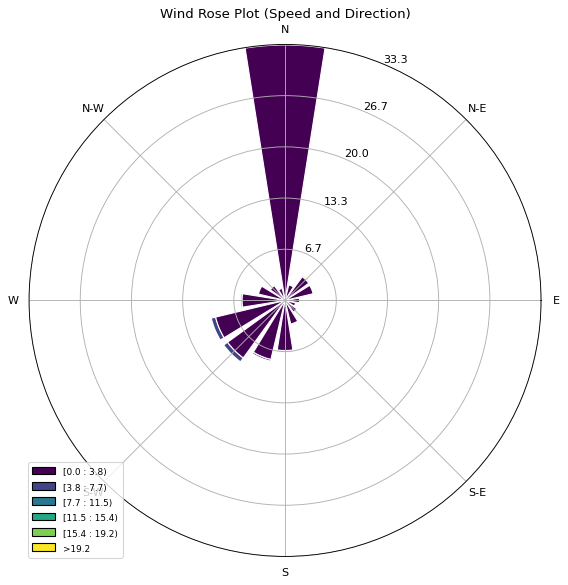

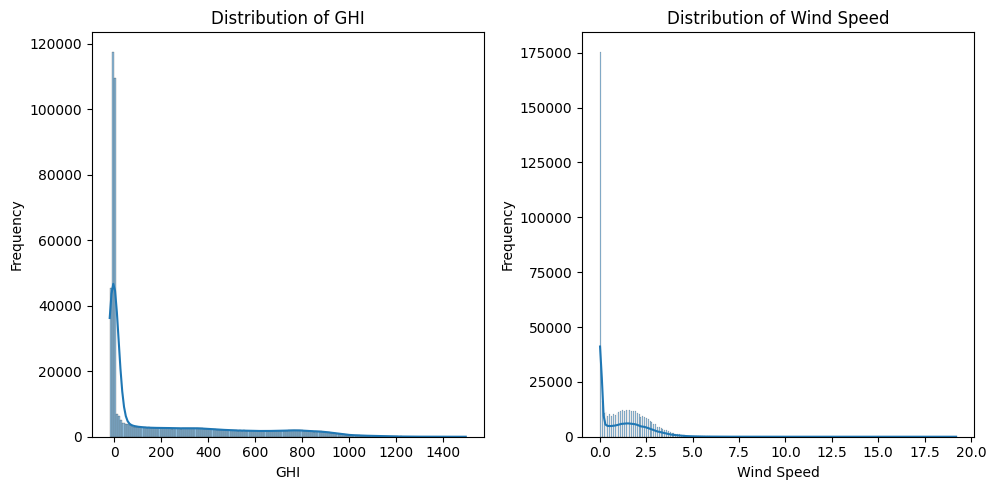

In [12]:
# Wind Rose Plot (example using windrose library)
# May need to adjust binning and other parameters
try:
    from windrose import WindroseAxes
    ax = WindroseAxes.from_ax()
    ax.bar(df_cleaned['WD'], df_cleaned['WS'], normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    plt.title('Wind Rose Plot (Speed and Direction)')
    plt.show()
except ImportError:
    print("Windrose library not found. Skipping wind rose plot.")
except Exception as e:
    print(f"Error generating wind rose plot: {e}")


# Histograms
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['GHI'], kde=True) # kde=True adds a kernel density estimate line
plt.title('Distribution of GHI')
plt.xlabel('GHI')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['WS'], kde=True) # Replace 'WS' with another variable like 'Tamb' or 'RH'
plt.title('Distribution of Wind Speed')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

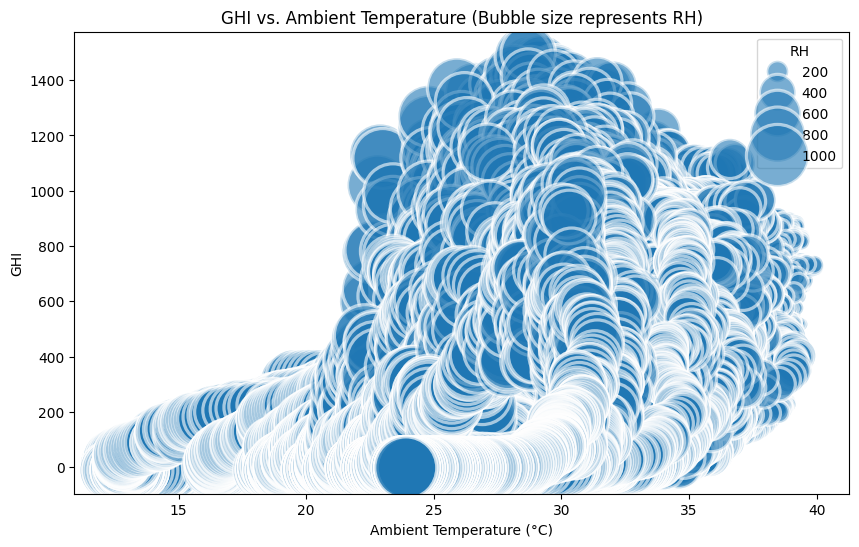

In [13]:
# Bubble Chart: GHI vs Tamb, bubble size = RH (example)
# Need to scale bubble size appropriately for visualization
# Ensure 'RH' or 'BP' column exists
bubble_size_col = 'RH' # Or 'BP'
if bubble_size_col in df_cleaned.columns:
    # Scale size for better visualization
    sizes = df_cleaned[bubble_size_col].fillna(df_cleaned[bubble_size_col].median()) * 10 # Adjust scaling factor (10) as needed

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Tamb', y='GHI', size=sizes, data=df_cleaned, alpha=0.6, sizes=(20, 2000)) # Adjust sizes range
    plt.title(f'GHI vs. Ambient Temperature (Bubble size represents {bubble_size_col})')
    plt.xlabel('Ambient Temperature (°C)')
    plt.ylabel('GHI')
    # Add legend if needed (can be tricky with size mapping)
    plt.show()
else:
    print(f"{bubble_size_col} column not found for bubble chart.")